In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.neural_network import MLPRegressor

In [160]:
with open("training.pkl", "rb") as f:
    df = pickle.load(f)

In [162]:
x = df[['x_pos', 'y_pos', 'x_vec', 'y_vec', 'x_dest', 'y_dest']].to_numpy()
y = df[['x_tar', 'y_tar']].to_numpy()

In [164]:
clf = MLPRegressor(verbose=True, hidden_layer_sizes=(4,100), max_iter=50).fit(x,y)

Iteration 1, loss = 2422.97968258
Iteration 2, loss = 7.76339507
Iteration 3, loss = 3.50140112
Iteration 4, loss = 2.75041414
Iteration 5, loss = 1.86029117
Iteration 6, loss = 1.48425952
Iteration 7, loss = 1.18841600
Iteration 8, loss = 1.03306715
Iteration 9, loss = 0.93182038
Iteration 10, loss = 0.85732969
Iteration 11, loss = 0.80367220
Iteration 12, loss = 0.75291223
Iteration 13, loss = 0.70070331
Iteration 14, loss = 0.66965190
Iteration 15, loss = 0.63118744
Iteration 16, loss = 0.59439072
Iteration 17, loss = 0.55831208
Iteration 18, loss = 0.53992833
Iteration 19, loss = 0.49833229
Iteration 20, loss = 0.47265749
Iteration 21, loss = 0.45358156
Iteration 22, loss = 0.43453887
Iteration 23, loss = 0.41213265
Iteration 24, loss = 0.39535221
Iteration 25, loss = 0.38602865
Iteration 26, loss = 0.35708944
Iteration 27, loss = 0.35127803
Iteration 28, loss = 0.33890974
Iteration 29, loss = 0.32062081
Iteration 30, loss = 0.30765659
Iteration 31, loss = 0.29033973
Iteration 32, 

C:\Users\marcu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


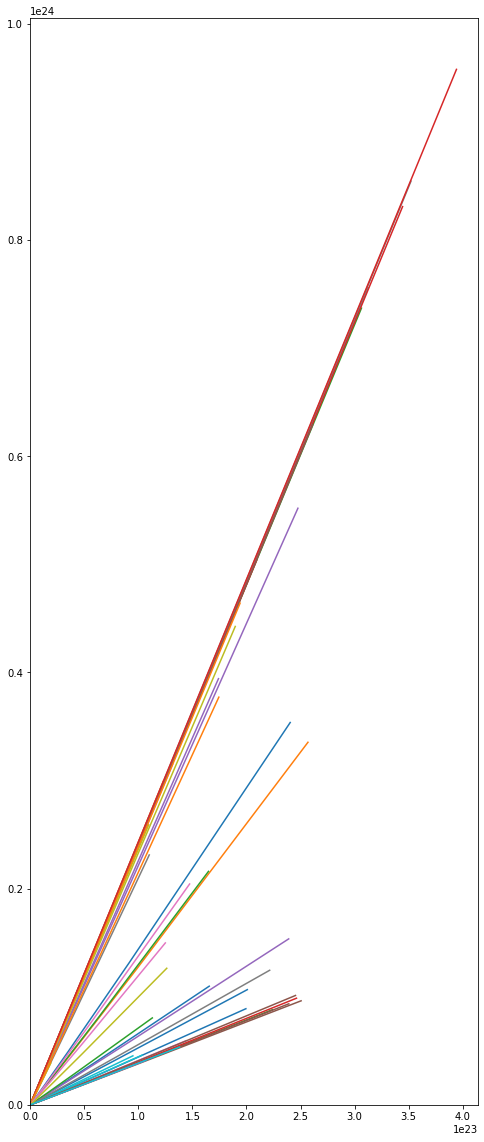

In [174]:
im = Image.open("intersection2.png")
im = ImageOps.flip(im)

# create figure
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(im, origin='lower')


for _ in range(40):
    x = np.array([[randint(0,600)*2, randint(0,350)*2, 0, 0, -250*2, 100*2]])
    for i in range(50):
        xx = np.concatenate((x[i][:2] + clf.predict(x[i:]), x[i][:2] + clf.predict(x[i:]) - x[i][:2], [x[i][4:]]), axis=1)
        x = np.concatenate((x,xx))
    jeff = x[:,:2]/2
    ax.plot(jeff[:,0], jeff[:,1])
    
    # load and process image
